### Part II: 
What will a new airbnb user's first booking destination be?

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
%store -r X_train2
%store -r X_test2
%store -r y_train2
%store -r y_test2
age_bkts = pd.read_csv('../data/age_gender_bkts.csv.zip')

In [9]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128070 entries, 202476 to 29828
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  128070 non-null  object
 1   gender              128070 non-null  object
 2   signup_method       128070 non-null  object
 3   affiliate_channel   128070 non-null  object
 4   affiliate_provider  128070 non-null  object
 5   signup_app          128070 non-null  object
 6   first_device_type   128070 non-null  object
 7   first_browser       128070 non-null  object
 8   english_lan         128070 non-null  bool  
 9   age_bins            128070 non-null  object
 10  effective_booking   128070 non-null  bool  
dtypes: bool(2), object(9)
memory usage: 10.0+ MB


### EDA

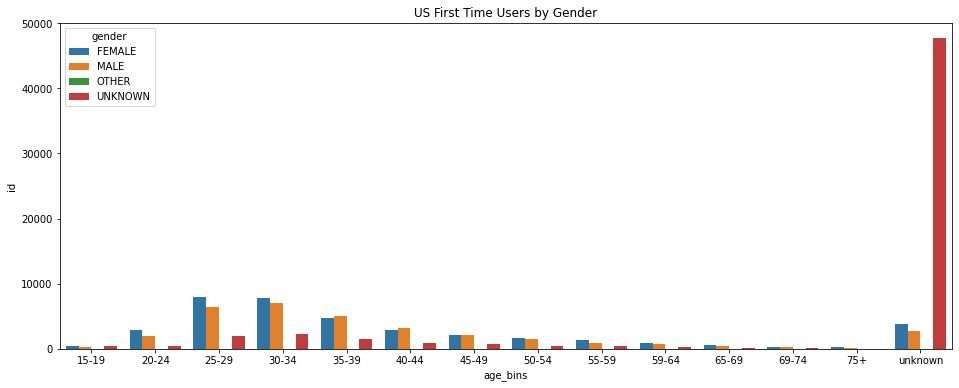

In [10]:
users_by_age = X_train2.groupby(['age_bins','gender']).agg({'id':'count'}).reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(y='id', x='age_bins', hue='gender', data=users_by_age)
plt.title('US First Time Users by Gender')
plt.show()

Which are the most popular destinations?

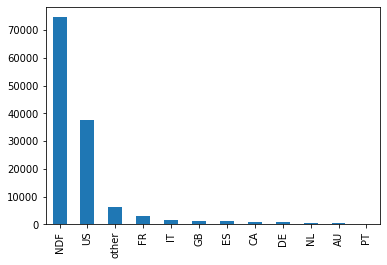

In [11]:
y_train2.value_counts().plot.bar()
plt.show()

In [12]:
age_bkts = age_bkts.drop(columns=['year'])

In [13]:
US = age_bkts.loc[age_bkts.country_destination == 'US']

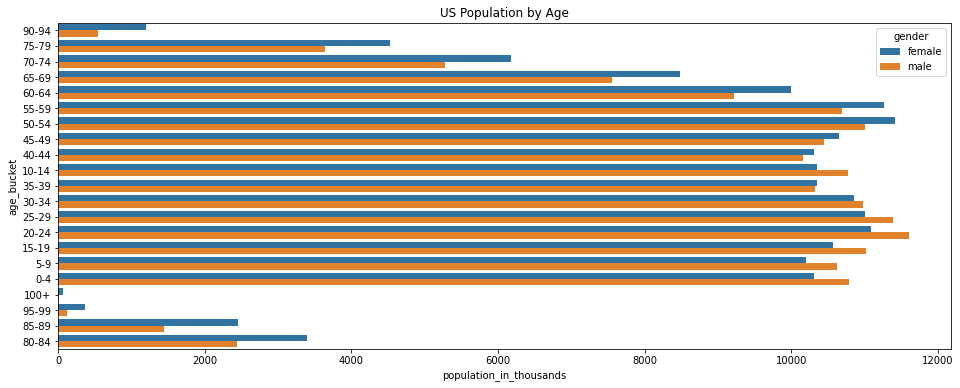

In [14]:
plt.figure(figsize=(16, 6))
sns.barplot(y='age_bucket', x='population_in_thousands', hue='gender', data=US)
plt.title('US Population by Age')
plt.show()

In [15]:
le = LabelEncoder()
ohe = OneHotEncoder()

In [16]:
X_train2 = X_train2.drop(columns=['id' 
                                  ])
X_test2 = X_test2.drop(columns=['id'
                                ])

In [17]:
# Label encoding
y_train_le = le.fit_transform(y_train2)
y_test_le = le.transform(y_test2)

In [18]:
# One hot encoding
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train2)
X_train_ohe.head()

,gender_UNKNOWN,gender_MALE,gender_FEMALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,affiliate_channel_direct,affiliate_channel_sem-non-brand,affiliate_channel_other,...,age_bins_65-69,age_bins_35-39,age_bins_45-49,age_bins_15-19,age_bins_20-24,age_bins_75+,age_bins_55-59,age_bins_59-64,age_bins_69-74,effective_booking
202476,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
206210,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False
149671,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False
11970,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
161330,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False


In [19]:
X_test_ohe = ohe.transform(X_test2)
X_test_ohe.head()

,gender_UNKNOWN,gender_MALE,gender_FEMALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,affiliate_channel_direct,affiliate_channel_sem-non-brand,affiliate_channel_other,...,age_bins_65-69,age_bins_35-39,age_bins_45-49,age_bins_15-19,age_bins_20-24,age_bins_75+,age_bins_55-59,age_bins_59-64,age_bins_69-74,effective_booking
97478,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
42544,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,False
144071,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
112119,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False
168245,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True


In [20]:
train_x = X_train_ohe.values
test_x = X_test_ohe.values

In [21]:
# Instantiate XGBClassifier
clf = XGBClassifier()

In [22]:
# Fit XGBClassifier
clf.fit(train_x, y_train_le)

# Predict on training and test sets
training_preds = clf.predict(train_x)
test_preds = clf.predict(test_x)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train_le, training_preds)
test_accuracy = accuracy_score(y_test_le, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 87.56%
Validation accuracy: 87.59%
